# Set-up

In [1]:
# standard library imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sequence data manipulation
import xarray as xr
import seqdata as sd
import seqpro as sp
from tangermeme.io import extract_loci
from tangermeme.predict import predict

# pytorch imports
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Model imports
from bpnetlite.bpnet import ControlWrapper, CountWrapper, ProfileWrapper
from bpnetlite.performance import calculate_performance_measures
from bpnetlite.chrombpnet import BPNet
from seqmodels import Module

# weasyprint Imports
from weasyprint import HTML, CSS

# change to the directory where the data is stored
os.chdir("/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair")

# Seaborn Styling
sns.set_style('white')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
path_splits = "/cellar/users/aklie/projects/ML4GLand/tutorials/data/splits/fold_0.json"
path_peaks = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_peaks.zarr"
path_negatives = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_negatives.zarr"

seq_len = 2114
target_len = 1000
max_jitter = 128
signal_beta = 0.5

n_filters = 128
n_layers = 4
alpha = 6

batch_size = 64
learning_rate = 0.001

path_out = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/v0.0.3"

# Read data

In [3]:
splits = json.load(open(path_splits, "r"))
train_chroms = splits["train"]
valid_chroms = splits["valid"]
test_chroms = splits["test"]

In [4]:
# Load the data
peaks = sd.open_zarr(path_peaks)
neg = sd.open_zarr(path_negatives)
peaks.dims["_sequence"], neg.dims["_sequence"]

(269718, 269692)

In [5]:
# Parameters
trimming = (seq_len - target_len) // 2

# Filter counts

In [6]:
# Split into training ad test
training_peaks = peaks.sel(_sequence=(peaks["chrom"].isin(train_chroms+valid_chroms)).compute())
training_neg = neg.sel(_sequence=(neg["chrom"].isin(train_chroms+valid_chroms)).compute())
test_neg = neg.sel(_sequence=(neg["chrom"].isin(test_chroms)).compute())
test_peaks = peaks.sel(_sequence=(peaks["chrom"].isin(test_chroms)).compute())

In [7]:
training_peak_counts = training_peaks["cov"][..., max_jitter+trimming:-max_jitter-trimming].sum(axis=(1,2)).values
training_neg_counts = training_neg["cov"][..., max_jitter+trimming:-max_jitter-trimming].sum(axis=(1,2)).values
training_peak_counts.shape, training_neg_counts.shape

((203244,), (228866,))

In [8]:
# Filter out negatives with too many counts
final_cnts = training_neg_counts
counts_threshold = np.quantile(training_peak_counts, 0.01) * signal_beta
assert(counts_threshold > 0) # counts threshold is 0 - all non peaks will be filtered!
final_cnts = final_cnts[final_cnts < counts_threshold]
upper_thresh = np.quantile(final_cnts, 0.999)
lower_thresh = np.quantile(final_cnts, 1-0.999)
negatives_msk = (training_neg_counts < upper_thresh) & (training_neg_counts > lower_thresh)
print(f"Filtered negatives: {np.sum(negatives_msk)}")
filtered_training_neg = training_neg.isel(_sequence=negatives_msk)
filtered_training_neg

Filtered negatives: 212074


<xarray.Dataset>
Dimensions:     (_sequence: 212074, cov_sample: 1, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) object 'K562_ATAC-seq'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object dask.array<chunksize=(18334,), meta=np.ndarray>
    chromEnd    (_sequence) int64 dask.array<chunksize=(18334,), meta=np.ndarray>
    chromStart  (_sequence) int64 dask.array<chunksize=(18334,), meta=np.ndarray>
    cov         (_sequence, cov_sample, _length) float32 dask.array<chunksize=(5434, 1, 2370), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(5434, 2370), meta=np.ndarray>
    strand      (_sequence) object dask.array<chunksize=(18334,), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [9]:
counts_loss_weight = np.median(final_cnts[(final_cnts < upper_thresh) & (final_cnts>lower_thresh)])/10

# Define architecture

In [12]:
arch = BPNet(
    n_filters=n_filters,
    n_layers=n_layers,
    n_outputs=1,
    n_control_tracks=0,
    trimming=trimming,
    alpha=counts_loss_weight,
    verbose=True,
)
arch

BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# Make dataloaders

In [13]:
train_neg = filtered_training_neg.sel(_sequence=(filtered_training_neg["chrom"].isin(train_chroms)).compute()).load()
valid_neg = filtered_training_neg.sel(_sequence=(filtered_training_neg["chrom"].isin(valid_chroms)).compute()).load()

In [15]:
def transform(batch):
    batch['seq'] = batch['seq'][..., max_jitter:-max_jitter]  # crop 
    batch['cov'] = batch['cov'][..., max_jitter+trimming:-max_jitter-trimming]  # crop 
    batch['seq'] = sp.DNA.ohe(batch['seq']).transpose(0, 2, 1)  # one hot encode
    batch['seq'] = sp.reverse_complement(batch['seq'], alphabet=sp.DNA, length_axis=-1, ohe_axis=1).copy()
    batch['cov'] = np.flip(batch['cov'], axis=-1).copy()
    return batch

In [16]:
# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    train_neg,
    sample_dims=['_sequence'],
    variables=['seq', 'cov'],
    prefetch_factor=None,
    batch_size=64,
    transform=transform,
    shuffle=True,
)
batch = next(iter(train_dl))
batch['seq'].shape, batch['cov'].shape

(torch.Size([64, 4, 2114]), torch.Size([64, 1, 1000]))

In [17]:
# Valid dataloader
valid_dl = sd.get_torch_dataloader(
    valid_neg,
    sample_dims=['_sequence'],
    variables=['seq', 'cov'],
    prefetch_factor=None,
    batch_size=64,
    transform=transform,
    shuffle=False,
)
batch = next(iter(valid_dl))
batch["seq"].shape, batch["cov"].shape

(torch.Size([64, 4, 2114]), torch.Size([64, 1, 1000]))

# Define training

In [18]:
from bpnetlite.losses import MNLLLoss, log1pMSELoss
from bpnetlite.performance import calculate_performance_measures

In [19]:
def bpnetlite_loss(outputs_dict, targets_dict, alpha=1):
    y_profile = outputs_dict['profile']
    y_counts = outputs_dict['counts'].reshape(-1, 1)
    y = targets_dict['cov']
    y_profile = y_profile.reshape(y_profile.shape[0], -1)
    y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
    y = y.reshape(y.shape[0], -1)
    profile_loss = MNLLLoss(y_profile, y)
    count_loss = log1pMSELoss(y_counts, y.sum(dim=-1).reshape(-1, 1))
    loss = profile_loss + alpha * count_loss
    return{
        "loss": loss,
        "profile_mnll": profile_loss,
        "count_mse": count_loss,
    }


def bpnetlite_metrics(outputs_dict, targets_dict, alpha=1):
    y_profile = outputs_dict['profile']
    y_counts = outputs_dict['counts']
    y = targets_dict['cov']
    z = y_profile.shape
    y_profile = y_profile.reshape(y_profile.shape[0], -1)
    y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
    y_profile = y_profile.reshape(*z)
    measures = calculate_performance_measures(
        y_profile, 
        y, 
        y_counts, 
        kernel_sigma=7, 
        kernel_width=81, 
        measures=['profile_mnll', 'profile_pearson', 'count_mse', 'count_pearson']
    )
    profile_mnll = measures['profile_mnll'].cpu()
    count_mse  = measures['count_mse'].cpu()
    profile_corr = measures['profile_pearson'].cpu()
    count_corr = measures['count_pearson'].cpu()
    loss = measures['profile_mnll'].cpu() + alpha * measures['count_mse'].cpu()
    return{
        "profile_mnll": profile_mnll,
        "count_mse": count_mse,
        "profile_pearson": profile_corr,
        "count_pearson": count_corr,
        "loss": loss,
    }

In [20]:
module = Module(
    arch=arch,
    input_vars=["seq"],
    output_vars=["profile", "counts"],
    target_vars=["cov"],
    loss_fxn=bpnetlite_loss,
    val_metrics_fxn=bpnetlite_metrics,
    val_metrics_kwargs={"alpha": arch.alpha},
    optimizer="adam",
    optimizer_lr=1e-3,
)

In [21]:
test_out = module({"seq": batch["seq"]})
targets_dict = {"cov": batch["cov"]}
out_dict = {"profile": test_out[0], "counts": test_out[1]}
test_metrics = module.val_metrics_fxn(out_dict, targets_dict)
test_losses = module.loss_fxn(out_dict, targets_dict)
test_metrics, test_losses

({'profile_mnll': tensor([[332.7759],
          [191.8995],
          [308.8595],
          [113.4297],
          [173.5519],
          [196.6901],
          [274.8454],
          [203.6257],
          [212.6971],
          [287.2435],
          [225.5979],
          [149.8976],
          [ 63.6794],
          [138.5811],
          [226.5263],
          [ 83.9655],
          [ 44.3945],
          [223.1241],
          [208.4838],
          [224.8537],
          [188.9950],
          [209.0836],
          [300.0471],
          [281.6086],
          [266.9490],
          [296.8959],
          [298.6401],
          [287.6480],
          [338.5974],
          [192.8215],
          [310.2742],
          [294.1131],
          [345.6955],
          [267.9663],
          [214.9431],
          [272.5824],
          [346.0196],
          [293.4422],
          [242.3047],
          [332.4284],
          [271.0701],
          [303.6652],
          [350.9987],
          [235.3302],
          [308.6

In [22]:
logger = CSVLogger(save_dir=path_out, name="", version="")

callbacks = [
    ModelCheckpoint(
        dirpath=os.path.join(
            logger.save_dir, 
            logger.name, 
            logger.version, 
            "checkpoints"
        ),
        save_top_k=5,
        monitor="val_loss_epoch",
    ),
    EarlyStopping(
        monitor="val_loss_epoch",
        patience=5,
        mode="min",
    ),
]

# Trainer
trainer = Trainer(
    logger=logger,
    callbacks=callbacks,
    max_epochs=50,
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/eugene_tools ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Fit models

In [ ]:
# Fit the weigths
trainer.fit(module, train_dl, valid_dl)

You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | arch            | BPNet         | 217 K  | train
1 | loss_fxn        | GeneralLoss   | 0      | train
2 | val_metrics_fxn | GeneralMetric | 0      | train
----------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 20:  42%|████▏     | 1269/2998 [00:37<00:51, 33.66it/s, train_loss=148.0, val_loss_epoch=166.0, val_profile_mnll_epoch=164.0, val_count_mse_epoch=0.334, val_profile_pearson_epoch=0.426, val_count_pearson_epoch=0.561, train_loss_epoch=158.0, train_profile_mnll_epoch=157.0, train_count_mse_epoch=0.431]

In [ ]:
# Get the best model weights
best_model_path = trainer.checkpoint_callback.best_model_path
copy_path = os.path.join(path_out, "best_model.ckpt")
os.system(f"cp {best_model_path} {copy_path}")     

# Training curves

In [34]:
bias_log_df = pd.read_csv(os.path.join(path_out, "metrics.csv"))
bias_log_df

AttributeError: 'Index' object has no attribute '_format_flat'

      epoch   step  train_count_mse_epoch  train_loss  train_loss_epoch  \
0         0     49                    NaN  162.508774               NaN   
1         0     99                    NaN  160.091034               NaN   
2         0    149                    NaN  170.420685               NaN   
3         0    199                    NaN  153.979858               NaN   
4         0    249                    NaN  160.328705               NaN   
...     ...    ...                    ...         ...               ...   
1605     25  77799                    NaN  151.390289               NaN   
1606     25  77849                    NaN  157.979858               NaN   
1607     25  77899                    NaN  165.952408               NaN   
1608     25  77947                    NaN         NaN               NaN   
1609     25  77947               0.420824         NaN        157.834808   

      train_profile_mnll_epoch  val_count_mse_epoch  val_count_pearson_epoch  \
0                  

In [ ]:
# log dataframe

bias_log_df["Training Loss"] = bias_log_df["Training MNLL"] + alpha*bias_log_df["Training Count MSE"]
bias_log_df["Validation Loss"] = bias_log_df["Validation MNLL"] + alpha*bias_log_df["Validation Count MSE"]
bias_log_df.head()

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?,Training Loss,Validation Loss
0,0,0,3.081924,4.638357,216.702850,18.638351,219.641678,0.146548,-0.083016,11.889074,True,328.532959,290.976124
32,1,3200,0.875983,4.525635,153.392090,0.646548,160.784027,0.405790,0.623615,0.690880,True,157.271379,164.929306
64,2,6400,1.747073,4.521678,153.425323,0.809450,160.424820,0.408205,0.697314,0.587702,False,158.282021,163.951033
96,3,9600,2.600977,4.519559,143.995819,1.364585,160.251785,0.408853,0.715799,0.701628,False,152.183328,164.461551
128,4,12800,3.454323,4.519546,149.421783,0.948719,160.155014,0.409781,0.727838,0.555521,False,155.114100,163.488137


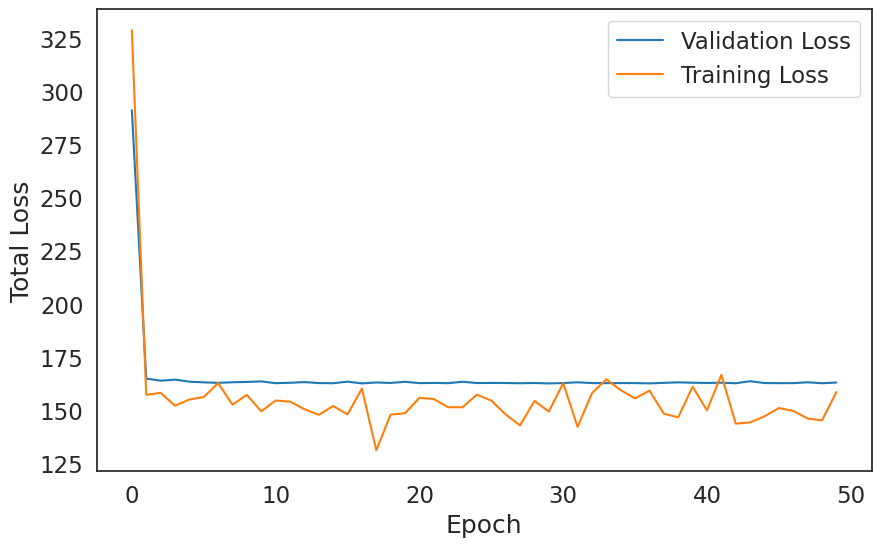

In [ ]:
# Plot losses vs "Epoch"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Epoch", y="Validation Loss", label="Validation Loss")
    sns.lineplot(data=bias_log_df, x="Epoch", y="Training Loss", label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.savefig(f"{path_evaluation}/K562.bias.epoch_loss.png", dpi=300)

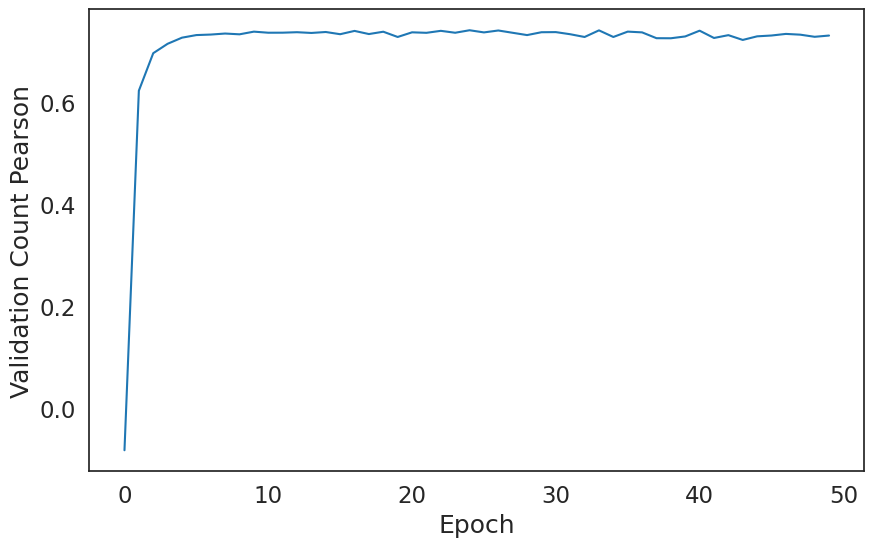

In [ ]:
# Plot "Validation Count Pearson" vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Epoch", y="Validation Count Pearson")
    plt.savefig(f"{path_evaluation}/K562.bias.epoch_val_count_pearson.png", dpi=300)

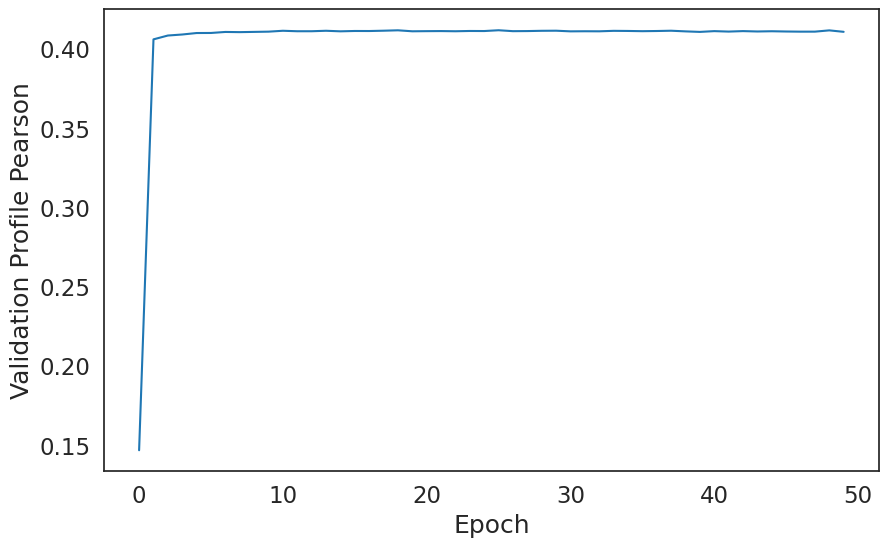

In [ ]:
# Plot "Validation Profile Pearson" vs "Iteration"
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bias_log_df, x="Epoch", y="Validation Profile Pearson")
    plt.savefig(f"{path_evaluation}/K562.bias.epoch_val_profile_pearson.png", dpi=300)

# Load bias model

In [38]:
path_bias_model = best_model_path

In [39]:
# Load the model
if path_bias_model.endswith(".h5"):
    bias_model = BPNet.from_chrombpnet(path_bias_model).cuda().eval()
elif path_bias_model.endswith(".torch"):
    bias_model = torch.load(path_bias_model, map_location="cuda").eval()
elif path_bias_model.endswith(".ckpt"):
    module = Module.load_from_checkpoint(path_bias_model, arch=arch)
    bias_model = module.arch.cuda().eval()
bias_model

BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# Bias model performance

In [40]:
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

def scatter(
    x,
    y,
    ax=None,
    density=False,
    c="b",
    alpha=1,
    s=10,
    xlabel="Observed",
    ylabel="Predicted",
    figsize=(4, 4),
    save=None,
    add_reference_line=True,
    rasterized=False,
    return_axes=False,
):
    # Set up the axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Drop NA values if any
    x_nas = np.isnan(x)
    y_nas = np.isnan(y)
    x = x[~x_nas & ~y_nas]
    y = y[~x_nas & ~y_nas]

    if density:
        # Get point densities
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        c=z

    # Plot the points
    ax.scatter(x, y, c=c, s=s, rasterized=rasterized, alpha=alpha)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add scores
    r2 = r2_score(x, y)
    pearson_r = pearsonr(x, y)
    spearman_r = spearmanr(x, y)
    ax.annotate(f"R2: {r2:.3f}", (0.05, 0.95), xycoords="axes fraction")
    ax.annotate(f"Pearson: {pearson_r[0]:.3f}", (0.05, 0.90), xycoords="axes fraction")
    ax.annotate(f"Spearman: {spearman_r[0]:.3f}", (0.05, 0.85), xycoords="axes fraction")
    
    # Add y=x line for reference but make the mins and maxes extend past the data
    if add_reference_line:
        min_val = min(min(x), min(y))
        max_val = max(max(x), max(y))
        ax.plot([min_val, max_val], [min_val, max_val], c="k", ls="--", lw=1)
    
    # Plt
    plt.tight_layout()

    # Save
    if save:
        plt.savefig(save, dpi=300)
        plt.close()
    else:
        plt.show()

    if return_axes:
        return ax
    
def log_softmax_profile(
    y_profile,
):
    # Log softmax the predicted profile
    z = y_profile.shape
    y_profile = y_profile.reshape(y_profile.shape[0], -1)
    y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
    y_profile = y_profile.reshape(*z)
    return y_profile

In [41]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
path_peaks = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/ENCSR868FGK_K562_ATAC-seq_peaks.bed"
path_negatives = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_negatives.bed"
path_signal = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_unstranded_counts.bw"
path_fa = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/hg38.fa"
path_splits = "/cellar/users/aklie/projects/ML4GLand/tutorials/data/splits/fold_0.json"
seq_len=2114

In [42]:
# Load test split
splits = json.load(open(path_splits, "r"))
chroms=splits["test"]
chroms

['chr1', 'chr3', 'chr6']

## Performance in peaks

In [43]:
recalculate_interval=True

In [44]:
# read peak
peak_df = pd.read_csv(path_peaks, sep="\t", header=None, names=NARROWPEAK_SCHEMA)
if recalculate_interval:
    peak_df["start"] = peak_df["start"] + peak_df["summit"] - seq_len // 2
    peak_df["end"] = peak_df["start"] + seq_len
peak_df = peak_df[peak_df["chr"].isin(chroms)]
print(f"Number of peak: {len(peak_df)}")

# extract peak
peak_seqs, peak_signals = extract_loci(
    peak_df,
    path_fa,
    signals=[path_signal],
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
)

# predict
peak_pred_profile, peak_predicted_counts = predict(model=bias_model, X=peak_seqs)

# log softmax
peak_pred_profile_probs = log_softmax_profile(peak_signals)

Number of peak: 66484


In [45]:
peak_counts = np.log(peak_signals.sum(axis=(1, 2)).cpu().detach().numpy() + 1)
peak_predicted_counts_np = peak_predicted_counts.squeeze().cpu().detach().numpy()
peak_counts.shape, peak_predicted_counts_np.shape

((66484,), (66484,))

In [61]:
scatter(
    peak_counts,
    peak_predicted_counts_np,
    xlabel="Log(raw counts+1)",
    ylabel="Predicted Log(raw counts+1)",
    add_reference_line=False,
    density=True,
    figsize=(8, 8),
    save=f"{path_out}/evaluation/K562.bias.peaks_pearsonr.png",
)

In [47]:
peak_measures = calculate_performance_measures(
    peak_pred_profile_probs,
    peak_signals,
    peak_predicted_counts, 
    measures=['profile_mnll', 'profile_pearson', 'profile_jsd', 'count_mse', 'count_pearson', 'count_spearman']
)

In [48]:
# We want to shuffle along the target_length axis preserving the other axes for each sequence
shuffled_peak_signals = peak_signals.clone()
for i in range(shuffled_peak_signals.shape[0]):
    shuffled_peak_signals[i] = shuffled_peak_signals[i, :, torch.randperm(shuffled_peak_signals.shape[2])]

peak_shuffled_measures = calculate_performance_measures(
    peak_pred_profile_probs,
    shuffled_peak_signals,
    peak_predicted_counts, 
    measures=['profile_jsd']
)

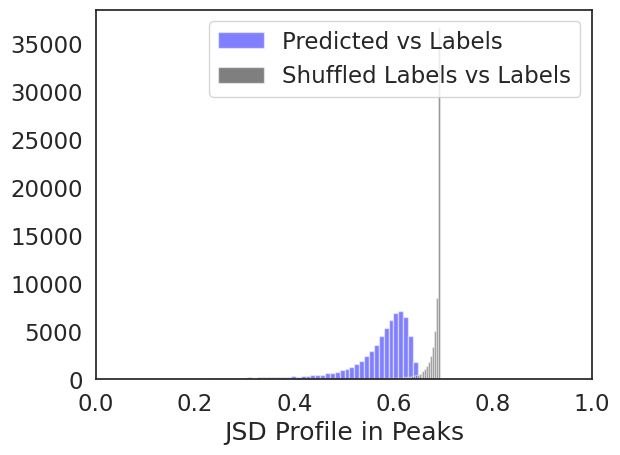

In [51]:
#plot jsd histogram
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure()
    n, bins, patches=plt.hist(peak_measures["profile_jsd"], 50, facecolor='blue', alpha=0.5, label="Predicted vs Labels")
    n1, bins1, patches1=plt.hist(peak_shuffled_measures["profile_jsd"], 50, facecolor='black', alpha=0.5,label='Shuffled Labels vs Labels')
    plt.xlim(0, 1)
    plt.xlabel('JSD Profile in Peaks')
    plt.legend(loc='best')
    plt.savefig(f"{path_out}/evaluation/K562.bias.peaks_jsd.png", dpi=300)

## Performance in negatives

In [52]:
recalculate_interval=False

In [53]:
# read negative
negative_df = pd.read_csv(path_negatives, sep="\t", header=None, names=NARROWPEAK_SCHEMA)
if recalculate_interval:
    negative_df["start"] = negative_df["start"] + negative_df["summit"] - seq_len // 2
    negative_df["end"] = negative_df["start"] + seq_len
negative_df = negative_df[negative_df["chr"].isin(chroms)]
print(f"Number of negative: {len(negative_df)}")

# extract negative
negative_seqs, negative_signals = extract_loci(
    negative_df,
    path_fa,
    signals=[path_signal],
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
)

# predict
negative_pred_signal, negative_predicted_counts = predict(model=bias_model, X=negative_seqs)

# log softmax
negative_pred_profile_probs = log_softmax_profile(negative_signals)

Number of negative: 40817


In [54]:
negative_counts = np.log(negative_signals.sum(axis=(1, 2)).cpu().detach().numpy() + 1)
negative_predicted_counts_np = negative_predicted_counts.squeeze().cpu().detach().numpy()
negative_counts.shape, negative_predicted_counts.shape

((40817,), torch.Size([40817, 1]))

In [62]:
scatter(
    negative_counts,
    negative_predicted_counts_np,
    xlabel="Log(raw counts+1)",
    ylabel="Predicted Log(raw counts+1)",
    add_reference_line=False,
    density=True,
    figsize=(8, 8),
    save=f"{path_out}/evaluation/K562.bias.negatives_pearsonr.png",
)

In [56]:
negative_measures = calculate_performance_measures(
    negative_pred_profile_probs,
    negative_signals,
    negative_predicted_counts, 
    measures=['profile_mnll', 'profile_pearson', 'profile_jsd', 'count_mse', 'count_pearson', 'count_spearman']
)

In [57]:
# We want to shuffle along the target_length axis preserving the other axes for each sequence
shuffled_negative_signals = negative_signals.clone()
for i in range(shuffled_negative_signals.shape[0]):
    shuffled_negative_signals[i] = shuffled_negative_signals[i, :, torch.randperm(shuffled_negative_signals.shape[2])]

negative_shuffled_measures = calculate_performance_measures(
    negative_pred_profile_probs,
    shuffled_negative_signals,
    negative_predicted_counts, 
    measures=['profile_jsd']
)

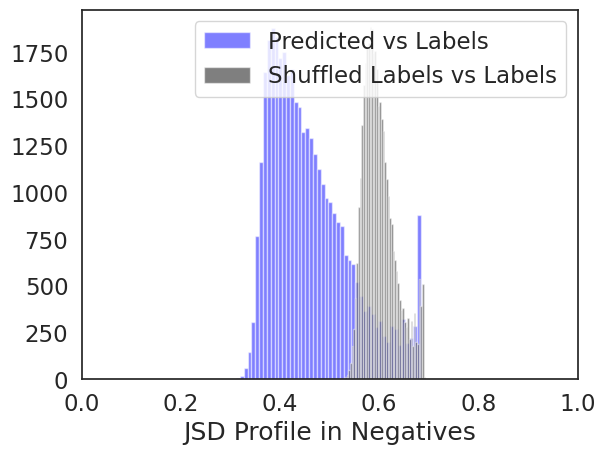

In [58]:
# plot jsd histogram
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure()
    n, bins, patches=plt.hist(negative_measures["profile_jsd"], 50, facecolor='blue', alpha=0.5, label="Predicted vs Labels")
    n1, bins1, patches1=plt.hist(negative_shuffled_measures["profile_jsd"], 50, facecolor='black', alpha=0.5,label='Shuffled Labels vs Labels')
    plt.xlim(0, 1)
    plt.xlabel('JSD Profile in Negatives')
    plt.legend(loc='best')
    plt.savefig(f"{path_out}/evaluation/K562.bias.negatives_jsd.png", dpi=300)

## Overall performance

In [59]:
metrics = {
    "counts_metrics": {
        "negatives": {
            "spearmanr": float(negative_measures["count_spearman"].item()),
            "pearsonr": float(negative_measures["count_pearson"].item()),
            "mse": float(negative_measures["count_mse"].item())
        },
        "peaks": {
            "spearmanr": float(peak_measures["count_spearman"].item()),
            "pearsonr": float(peak_measures["count_pearson"].item()),
            "mse": float(peak_measures["count_mse"].item())
        },
        "profile_metrics": {
            "negatives": {
                "median_jsd": float(np.nanmedian(negative_measures["profile_jsd"])),
                "median_shuffled_jsd": float(np.nanmedian(negative_shuffled_measures["profile_jsd"]))
            },
            "peaks": {
                "median_jsd": float(np.nanmedian(peak_measures["profile_jsd"])),
                "median_shuffled_jsd": float(np.nanmedian(peak_shuffled_measures["profile_jsd"]))
            }
        }
    }
}

In [60]:
import json
with open(f"{path_out}/evaluation/K562.bias.metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Contribution scores from bias model using `bpnet-lite`

In [ ]:
path_subsample_peaks = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/auxiliary/K562_30K_subsample_peaks.bed"
path_out = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample"

In [ ]:
X = extract_loci(
    loci=path_subsample_peaks,
    sequences=path_fa,
    max_jitter=0,
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
    verbose=True,
)
X.shape

Loading Loci: 100%|██████████| 30000/30000 [00:06<00:00, 4896.75it/s]


torch.Size([30000, 4, 2114])

In [ ]:
X = X[X.sum(dim=(1, 2)) == X.shape[-1]]
X.shape

torch.Size([29997, 4, 2114])

In [ ]:
np.savez_compressed(os.path.join(path_out, "ohe"), X)

```bash
profile_json=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_attribute_profile.json
counts_json=/celljson=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_attribute_counts.json
bpnet attribute -p $profile_json
bpnet attribute -p $counts_json
```

# TF-modisco motifs

In [ ]:
def convert_html_to_pdf(
	input_html,
	output_pdf
):
	css = CSS(string='''
		@page {
    		size: 1800mm 1300mm;
    		margin: 0in 0in 0in 0in;
		}
	''')
	HTML(input_html).write_pdf(output_pdf, stylesheets=[css])

## Counts contribution scores

```bash
ohe=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample/ohe.npz
attrs=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample/K562.bias.counts.npz
modisco_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/auxiliary/interpret_subsample/K562.bias.counts.modisco.h5
cmd="modisco motifs \
-s $ohe \
-a $attrs \
-n 50000 \
-w 500 \
-o $modisco_out"
echo $cmd
eval $cmd

report_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation/modisco_counts
motifs=/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt
cmd="modisco report \
-i $modisco_out \
-o $report_out \
-s $report_out \
-m $motifs"
echo $cmd
eval $cmd
```

```bash

```

In [ ]:
convert_html_to_pdf(
    input_html="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation/modisco_counts/motifs.html",
    output_pdf="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/bpnet-lite/bias_model/evaluation/K562.bias.counts.pdf"
)

## Profile contribution scores

```bash
ohe=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/ohe.npz
attrs=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.npz
modisco_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.modisco.h5
cmd="modisco motifs \
-s $ohe \
-a $attrs \
-n 50000 \
-w 500 \
-o $modisco_out"
echo $cmd
eval $cmd

report_out=/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_profile
motifs=/cellar/users/aklie/projects/ML4GLand/tutorials/data/motifs.meme.txt
cmd="modisco report \
-i $modisco_out \
-o $report_out \
-s $report_out \
-m $motifs"
echo $cmd
eval $cmd
```
```

In [ ]:
convert_html_to_pdf(
    input_html="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/modisco_profile/motifs.html",
    output_pdf="/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/chrombpnet/bias_model/chrombpnet-lite_evaluation/K562.bias.profile.pdf"
)

# DONE!

---